## Imports

In [5]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import NumeralTickFormatter
from bokeh.models import ColumnDataSource
from bokeh.layouts import gridplot
from bokeh.io import curdoc

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import tensorflow as tf

from scipy import stats
import pandas as pd
import numpy as np 
import random

from datetime import datetime as dt
from datetime import timedelta
import calendar

from bs4 import BeautifulSoup
import requests

import matplotlib.pyplot as plt

import MetaTrader5 as mt5

In [9]:
%matplotlib inline
pd.set_option('display.max_rows', 5000)
curdoc().theme = 'caliber'

## Define dataframes for currencies

In [10]:
Currency_Columns = ["Date","Symbol","Long","Short","Change Long","Change Short","Net positions","Total positions","Open interest"]
CAD_df = pd.DataFrame(columns=Currency_Columns)
CHF_df = pd.DataFrame(columns=Currency_Columns)
GBP_df = pd.DataFrame(columns=Currency_Columns)
JPY_df = pd.DataFrame(columns=Currency_Columns)
EUR_df = pd.DataFrame(columns=Currency_Columns)
NZD_df = pd.DataFrame(columns=Currency_Columns)

In [11]:
CAD_df = pd.read_csv("CAD.csv",parse_dates=["Date"])
CHF_df = pd.read_csv("CHF.csv",parse_dates=["Date"])
GBP_df = pd.read_csv("GBP.csv",parse_dates=["Date"])
JPY_df = pd.read_csv("JPY.csv",parse_dates=["Date"])
EUR_df = pd.read_csv("EUR.csv",parse_dates=["Date"])
NZD_df = pd.read_csv("NZD.csv",parse_dates=["Date"])

In [12]:
NZD_df

,Date,Symbol,Long,Short,Change Long,Change Short,Net positions,Total positions,Open interest
0,2021-03-09,NEW ZEALAND DOLLAR,32664,15538,839,121,17126,48202,51380
1,2021-03-02,NEW ZEALAND DOLLAR,31825,15417,1403,-356,16408,47242,48587
2,2021-02-02,NEW ZEALAND DOLLAR,30501,18854,2324,5435,11647,49355,50685
3,2021-02-09,NEW ZEALAND DOLLAR,29133,17589,-1368,-1265,11544,46722,48655
4,2021-02-16,NEW ZEALAND DOLLAR,30243,16532,1110,-1057,13711,46775,48103
5,2021-02-23,NEW ZEALAND DOLLAR,30422,15773,179,-759,14649,46195,48209
6,2021-01-05,NEW ZEALAND DOLLAR,26552,14556,-1287,-749,11996,41108,47194
7,2021-01-12,NEW ZEALAND DOLLAR,26131,11424,-421,-3132,14707,37555,44757
8,2021-01-19,NEW ZEALAND DOLLAR,27997,12014,1866,590,15983,40011,46244
9,2021-01-26,NEW ZEALAND DOLLAR,28177,13419,180,1405,14758,41596,46804


## Defining trade dataframes

* Trade the biggest net position always ***v1***
* Trade when the change on one side is negative and the other is positivie ***v2***
* Trade the biggest position when the changes on this are positive and the opposite position are negative ***v3***

   _***s*** dataframes take the trades with the same condition but 7 days after the report's signal_

In [13]:
Trades_columns = ["Date","Position","Symbol","Duration","Result"]

Trades_v1 = pd.DataFrame(columns=Trades_columns)
Trades_v2 = pd.DataFrame(columns=Trades_columns)
Trades_v3 = pd.DataFrame(columns=Trades_columns)

In [14]:
Trades_v4 = pd.DataFrame(columns=Trades_columns)
Trades_v5 = pd.DataFrame(columns=Trades_columns)
Trades_v6 = pd.DataFrame(columns=Trades_columns)

## Browser headers and url

In [15]:
headers = [{'User-agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:61.0) Gecko/20100101 Firefox/61.0'},
           {'User-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36'}]

In [16]:
url_current_report = "https://www.cftc.gov/dea/futures/deacmesf.htm"
url_current_home = "https://www.cftc.gov/MarketReports/CommitmentsofTraders/index.htm"
url_historical_home = "https://www.cftc.gov/MarketReports/CommitmentsofTraders/HistoricalViewable/index.htm"
structure_chicago_mercantile_exchange_url = "https://www.cftc.gov/sites/default/files/files/dea/cotarchives/{}/futures/deacmesf{}.htm"

## Retrieve the last report  (text)

In [17]:
request_current = requests.get(url_current_report, headers=random.choice(headers))

In [18]:
soup_current = BeautifulSoup(request_current.content,"html.parser")

In [19]:
reports_current = soup_current.find("pre").text.split("\r\n \r\n \r\n")

In [20]:
reports_current.remove("")

## Define the date of the lastest report

In [22]:
dateInfo = BeautifulSoup(requests.get(url_current_home, headers=random.choice(headers)).content,"html.parser").find_all("strong")
for element in dateInfo:
    if element.text.split(" ")[0] == "Reports" and element.text.split(" ")[1] == "Dated":
        dateInfo = element.text.replace(",","").replace("\xa0"," ").split(" ")
        break
dateLast = dt(int(dateInfo[4]),int(list(calendar.month_name).index(dateInfo[2])),int(dateInfo[3]))

## Retrieve locators of historical reports (url)

In [16]:
historical_urls = []

In [17]:
request_historical = requests.get(url_historical_home, headers=random.choice(headers))

In [18]:
soup_historical = BeautifulSoup(request_historical.content,"html.parser")

In [19]:
for table in soup_historical.find_all("table"):
    
    for element in table.find_all("a"):
        
        href = element.get("href")
        
        if href != None and href[-4:] != ".htm":
            
            if element.get("href")[-4:] == "html": addr = "/MarketReports/CommitmentsofTraders/HistoricalViewable/"+element.get("href")[:-5]  
            else: addr = element.get("href")[-6:]
                
            month = addr[-6:][:2]
            day = addr[-6:][2:4]
            year = addr[-6:][4:]
            historical_urls.append(structure_chicago_mercantile_exchange_url.format("20" + year,month+day+year))

## Helper function

In [20]:
def remove_blank(data):
    final_data = []
    for point in data:
        if point != "":
            final_data.append(point)
    return final_data

## Appending filtered values to the initial dataframes from the ***current*** report

In [21]:
for i in range(0,len(reports_current)):
    
    name = reports_current[i].split("-")[0]
    commitments = reports_current[i].split("\r\n")
    
    OI_filled = False
    
    try:
        int(GBP_df.loc[GBP_df['Date'] == dateLast]["Long"].values)
        int(CHF_df.loc[CHF_df['Date'] == dateLast]["Long"].values)
        int(CAD_df.loc[CAD_df['Date'] == dateLast]["Long"].values)
        int(JPY_df.loc[JPY_df['Date'] == dateLast]["Long"].values)
        int(EUR_df.loc[EUR_df['Date'] == dateLast]["Long"].values)
        int(NZD_df.loc[NZD_df['Date'] == dateLast]["Long"].values)
        continue
    except TypeError: pass

    for j in commitments:
        for z in range(0,len(j.split(" "))):
            if j.split(" ")[z] == "INTEREST:" and OI_filled == False:
                OI = int(j.split(" ")[-1].replace(",",""))
                OI_filled = True
     
    for j in range(0,len(commitments)):
        if commitments[j] == "COMMITMENTS": positions = remove_blank(commitments[j+1].split(" "))
           
    for j in range(0,len(commitments)):
        if commitments[j].split(" ")[0] == "CHANGES": changes = remove_blank(commitments[j+1].split(" "))
     
    for y in range(0,len(positions)):
        try: positions[y] = int(positions[y].replace(",",""))
        except AttributeError:positions[y] = positions[y]
            
    for y in range(0,len(changes)):
        try: changes[y] = int(changes[y].replace(",",""))
        except ValueError: changes[y] = "0,0"
        except AttributeError: changes[y] = changes[y]

    try: row = [dateLast,name,positions[0],positions[1],changes[0],changes[1],positions[0] - positions[1],positions[0] + positions[1],OI]
    except IndexError: row = [0,0,0,0,0,0,0,0,0]
        
    if name == "CANADIAN DOLLAR ":CAD_df.loc[len(CAD_df)] = row
    if name == "SWISS FRANC ":CHF_df.loc[len(CHF_df)] = row    
    if name == "BRITISH POUND STERLING ":GBP_df.loc[len(GBP_df)] = row    
    if name == "JAPANESE YEN ":JPY_df.loc[len(JPY_df)] = row     
    if name == "EURO FX ":EUR_df.loc[len(EUR_df)] = row     
    if name == "NEW ZEALAND DOLLAR ":NZD_df.loc[len(NZD_df)] = row
        

## Appending filtered values to the initial dataframes from the ***historical*** reports

In [19]:
for url in historical_urls:
    
    request = requests.get(url, headers=random.choice(headers))
    soup = BeautifulSoup(request.content,"html.parser")
    
    try: reports = soup.find("pre").text.split("\r\n \r\n \r\n")
    except AttributeError:continue

    if len(reports) < 2:
        reports = soup.find("pre").text.split("\n \n \n")

    try: reports.remove("")
    except ValueError: pass

    month = int (url[-10:-8])
    day = int (url[-8:-6])
    year = int ("20"+url[-6:-4])
    date = dt(year,month,day)
    
    try:
        int(GBP_df.loc[GBP_df['Date'] == date]["Long"].values)
        int(CHF_df.loc[CHF_df['Date'] == date]["Long"].values)
        int(CAD_df.loc[CAD_df['Date'] == date]["Long"].values)
        int(JPY_df.loc[JPY_df['Date'] == date]["Long"].values)
        int(EUR_df.loc[EUR_df['Date'] == date]["Long"].values)
        int(NZD_df.loc[NZD_df['Date'] == date]["Long"].values)
        continue
    except TypeError: pass
    
    for i in range(0,len(reports)):
    
        name = reports[i].split("-")[0]
        commitments = reports[i].split("\r\n")
        
        OI_filled = False

        for j in range(0,len(commitments)):
            for i in range(0,len(remove_blank(commitments[j].split(" ")))):
                if remove_blank(commitments[j].split(" "))[i] == "INTEREST:" and OI_filled == False:
                    try: OI = int(remove_blank(commitments[j].split(" "))[i+1].replace(",",""))
                    except: OI = int(remove_blank(commitments[j].split(" "))[i+1].replace(",","").split("\n")[0])
                    OI_filled = True

        for j in range(0,len(commitments)):
            if commitments[j] == "COMMITMENTS": positions = remove_blank(commitments[j+1].split(" "))

        for j in range(0,len(commitments)):
            if commitments[j].split(" ")[0] == "CHANGES": changes = remove_blank(commitments[j+1].split(" "))

        for y in range(0,len(positions)):
            try: positions[y] = int(positions[y].replace(",",""))
            except AttributeError:positions[y] = positions[y]

        for y in range(0,len(changes)):
            try: changes[y] = int(changes[y].replace(",",""))
            except ValueError: changes[y] = "0,0"
            except AttributeError: changes[y] = changes[y]

        try: row = [date,name,positions[0],positions[1],changes[0],changes[1],positions[0] - positions[1],positions[0] + positions[1],OI]
        except IndexError: row = [0,0,0,0,0,0,0,0,0]

           
        if name == "CANADIAN DOLLAR ":CAD_df.loc[len(CAD_df)] = row
        if name == "SWISS FRANC ":CHF_df.loc[len(CHF_df)] = row    
        if name == "BRITISH POUND STERLING ":GBP_df.loc[len(GBP_df)] = row    
        if name == "JAPANESE YEN ":JPY_df.loc[len(JPY_df)] = row     
        if name == "EURO FX ":EUR_df.loc[len(EUR_df)] = row     
        if name == "NEW ZEALAND DOLLAR ":NZD_df.loc[len(NZD_df)] = row

In [22]:
CAD_df = CAD_df.drop_duplicates()
CHF_df = CHF_df.drop_duplicates()
GBP_df = GBP_df.drop_duplicates()
JPY_df = JPY_df.drop_duplicates()
EUR_df = EUR_df.drop_duplicates()
NZD_df = NZD_df.drop_duplicates()

In [23]:
CAD_df.to_csv("CAD.csv", index = False)
CHF_df.to_csv("CHF.csv", index = False)
GBP_df.to_csv("GBP.csv", index = False)
JPY_df.to_csv("JPY.csv", index = False)
EUR_df.to_csv("EUR.csv", index = False)
NZD_df.to_csv("NZD.csv", index = False)

In [42]:
GBP_df = GBP_df.sort_values(by=["Date"])

## Symbol daily closing prices

In [25]:
mt5.initialize()

True

In [26]:
date_from = dt(2005,1,1)
date_to = dt.now() - timedelta(days=1)

In [27]:
EURUSD_rates = mt5.copy_rates_range("EURUSD", mt5.TIMEFRAME_D1, date_from, date_to)
EURUSD_rates_frame = pd.DataFrame(EURUSD_rates)
EURUSD_rates_frame['time']=pd.to_datetime(EURUSD_rates_frame['time'], unit='s')

In [28]:
GBPUSD_rates = mt5.copy_rates_range("GBPUSD", mt5.TIMEFRAME_D1, date_from, date_to)
GBPUSD_rates_frame = pd.DataFrame(GBPUSD_rates)
GBPUSD_rates_frame['time']=pd.to_datetime(GBPUSD_rates_frame['time'], unit='s')

In [29]:
mt5.shutdown()

True

## Create columns with percentiles relative to the net positions, net positions adjusted to open interest and shift of net positions from positive to negative

In [30]:
GBP_df["Release"] = GBP_df["Date"].apply(lambda x: x + timedelta(days=7))
GBP_df["Percentile"] = GBP_df["Net positions"].apply(lambda x:stats.percentileofscore(np.array(GBP_df.sort_values(by=["Date"])["Net positions"]), x))
GBP_df.loc[GBP_df['Net positions'] < 0, 'Step'] = -1
GBP_df.loc[GBP_df['Net positions'] > 0, 'Step'] = 1
GBP_df["Adj OI"] = GBP_df['Net positions'] / GBP_df['Open interest']
GBP_df["Percentile Adj OI"] = GBP_df["Adj OI"].apply(lambda x:stats.percentileofscore(np.array(GBP_df.sort_values(by=["Date"])["Adj OI"]), x))

## Graphing price-action vs net positions and short/long positions

In [31]:
net_positions = figure(height=400,width=800,title = 'Positions vs Time',x_axis_label = 'Date',y_axis_label = 'Net positions',x_axis_type='datetime')
net_positions.line(GBP_df.sort_values(by=["Date"])["Date"],GBP_df.sort_values(by=["Date"])["Net positions"],line_width = 2,color = "green",legend_label="Net positions_")

positions = figure(y_range = (min(GBP_df["Long"].min(),GBP_df["Short"].min()),max(GBP_df["Long"].max(),GBP_df["Short"].max())),height=400,width=800,title = 'Positions vs Time',x_axis_label = 'Date',y_axis_label = 'Positions',x_axis_type='datetime')
positions.line(GBP_df.sort_values(by=["Date"])["Date"],GBP_df.sort_values(by=["Date"])["Long"],line_width = 2,color = "blue",legend_label="Long positions_")
positions.line(GBP_df.sort_values(by=["Date"])["Date"],GBP_df.sort_values(by=["Date"])["Short"],line_width = 2,color = "red",legend_label="Short positions_")

rates = figure(height=400,width=800,title = 'GBPUSD',x_axis_label = 'Date',y_axis_label = 'Rate',x_axis_type='datetime')
rates.line(GBPUSD_rates_frame["time"],GBPUSD_rates_frame["close"],color="darkorange",legend_label="rates",line_width=2)

percentiles = figure (height=400,width=800,y_range = (-1,1),title = 'Net Positions / OI vs Time',x_axis_label = 'Date',y_axis_label = '%',x_axis_type='datetime')
percentiles.line(GBP_df.sort_values(by=["Date"])["Date"],GBP_df.sort_values(by=["Date"])["Adj OI"],color="cyan",legend_label="Adj OI",line_width=2)


GlyphRenderer(id='1241', ...)

## Appending price after release date && reoganizing columns

In [50]:
def getRates(rates_days_delta):
    ratesDa = []
    for i in range(0,len(GBP_df)):
        rd = GBP_df.loc[i]["Release"] + timedelta(days=rates_days_delta)
        
        appended = None
        if rd > dt.now():
            dr = rd - timedelta(days=rates_days_delta)
            while appended == None:
                try:
                    ratesDa.append(float(GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == rd]["close"]))
                    appended = 0
                except:
                    rd = rd - timedelta(days=1)
            continue
        
        while appended == None:
            try:
                ratesDa.append(float(GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == rd]["close"]))
                appended = 0
            except:
                rd = rd - timedelta(days=1)
                
    return ratesDa

In [51]:
GBP_df["Rates dA"] = getRates(16)

In [52]:
GBP_df = GBP_df.reindex(['Date', 'Symbol','Release', 'Long', 'Short', 'Change Long', 'Change Short',
       'Net positions', 'Total positions', 'Open interest', 'Percentile',
       'Step', 'Adj OI', 'Percentile Adj OI', 'Rates dA'], axis=1)

## Data preprocessing

In [53]:
sc = MinMaxScaler(feature_range=(0,1))

X = GBP_df.iloc[:,3:-1]
y = GBP_df.iloc[:,-1]

X = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## ML predictions

---
DNN

In [54]:
tf_formated_cols = ['long', 'short', 'changeLong', 'changeShort', 'netPositions',
       'totalPositions', 'openInterest', 'percentile', 'step', 'adjOi',
       'percentileAdjOi']

In [55]:
GBP_df.columns

Index(['Date', 'Symbol', 'Release', 'Long', 'Short', 'Change Long',
       'Change Short', 'Net positions', 'Total positions', 'Open interest',
       'Percentile', 'Step', 'Adj OI', 'Percentile Adj OI', 'Rates dA'],
      dtype='object')

In [56]:
X_train_est = pd.DataFrame(data=X_train,
                           columns=tf_formated_cols,
                          index=y_train.index)

X_test_est = pd.DataFrame(data=X_test,
                          columns=tf_formated_cols,
                         index=y_test.index)

y_train_est = pd.DataFrame(data=y_train,
                          columns=['Rates dA'],
                         index=y_train.index)

y_test_est = pd.DataFrame(data=y_test,
                          columns=['Rates dA'],
                         index=y_test.index)

In [57]:
long = tf.feature_column.numeric_column('long')
short = tf.feature_column.numeric_column('short')
change_long = tf.feature_column.numeric_column('changeLong')
change_short = tf.feature_column.numeric_column('changeShort')
nett = tf.feature_column.numeric_column('netPositions')
total = tf.feature_column.numeric_column('totalPositions')
oi = tf.feature_column.numeric_column('openInterest')
percent = tf.feature_column.numeric_column('percentile')
step = tf.feature_column.numeric_column('step')
adjoi = tf.feature_column.numeric_column('adjOi')
adjoipercent = tf.feature_column.numeric_column('percentileAdjOi')

In [58]:
feature_columns = [long,short,change_long,change_short,nett,total,oi,percent,step,adjoi,adjoipercent]

In [122]:
train_function = tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_train_est,
                                                     y=y_train,
                                                     num_epochs=10000,
                                                     batch_size=10,
                                                     shuffle=True)

evaluate_function = tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_test_est,
                                                                  y=y_test,
                                                                  batch_size=10,
                                                                  num_epochs=1000,
                                                                  shuffle=False)

predict_function = tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_test_est,
                                                       batch_size=10,
                                                       num_epochs=1,
                                                       shuffle=False)



In [123]:
dnn_model = tf.compat.v1.estimator.DNNRegressor(hidden_units=[11,20,30,20,11],feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\KKK~1\\AppData\\Local\\Temp\\tmpz7nhd4o_', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [124]:
dnn_model.train(input_fn=train_function,steps=55000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\KKK~1\AppData\Local\Temp\tmpz7nhd4o_\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 33.26552, step = 0
INFO:tensorflow:global_step/sec: 604.019
INFO:tensorflow:loss = 0.5436926, step = 100 (0.167 sec)
INFO:tensorflow:global_step/sec: 668.449
INFO:tensorflow:loss = 0.45964348, step = 200 (0.152 sec)
INFO:tensorflow:global_step/sec: 677.482
INFO:tensorflow:loss = 0.2494225, step = 300 (0.145 sec)
INFO:tensorflow:global_step/sec: 663.903
INFO:tensorflow:loss = 0.077255785, step = 400 (0.151 sec)
INFO:tensorflow:global_step/sec: 673.058
INFO:tensorflow:loss = 0.2841985

INFO:tensorflow:global_step/sec: 759.447
INFO:tensorflow:loss = 0.076394804, step = 7800 (0.130 sec)
INFO:tensorflow:global_step/sec: 783.5
INFO:tensorflow:loss = 0.32051393, step = 7900 (0.127 sec)
INFO:tensorflow:global_step/sec: 777.268
INFO:tensorflow:loss = 0.13413146, step = 8000 (0.130 sec)
INFO:tensorflow:global_step/sec: 668.447
INFO:tensorflow:loss = 0.13450202, step = 8100 (0.151 sec)
INFO:tensorflow:global_step/sec: 779.389
INFO:tensorflow:loss = 0.1262283, step = 8200 (0.127 sec)
INFO:tensorflow:global_step/sec: 756.231
INFO:tensorflow:loss = 0.139281, step = 8300 (0.132 sec)
INFO:tensorflow:global_step/sec: 726.572
INFO:tensorflow:loss = 0.29569432, step = 8400 (0.138 sec)
INFO:tensorflow:global_step/sec: 711.112
INFO:tensorflow:loss = 0.17106333, step = 8500 (0.141 sec)
INFO:tensorflow:global_step/sec: 720.249
INFO:tensorflow:loss = 0.12945205, step = 8600 (0.139 sec)
INFO:tensorflow:global_step/sec: 748.129
INFO:tensorflow:loss = 0.06645049, step = 8700 (0.134 sec)
INFO

INFO:tensorflow:global_step/sec: 682.092
INFO:tensorflow:loss = 0.17383832, step = 16000 (0.147 sec)
INFO:tensorflow:global_step/sec: 765.226
INFO:tensorflow:loss = 0.07772841, step = 16100 (0.131 sec)
INFO:tensorflow:global_step/sec: 771.31
INFO:tensorflow:loss = 0.20613478, step = 16200 (0.130 sec)
INFO:tensorflow:global_step/sec: 771.441
INFO:tensorflow:loss = 0.18037309, step = 16300 (0.130 sec)
INFO:tensorflow:global_step/sec: 774.723
INFO:tensorflow:loss = 0.12805867, step = 16400 (0.129 sec)
INFO:tensorflow:global_step/sec: 815.183
INFO:tensorflow:loss = 0.07658519, step = 16500 (0.123 sec)
INFO:tensorflow:global_step/sec: 770.028
INFO:tensorflow:loss = 0.3639696, step = 16600 (0.129 sec)
INFO:tensorflow:global_step/sec: 753.739
INFO:tensorflow:loss = 0.043422475, step = 16700 (0.134 sec)
INFO:tensorflow:global_step/sec: 716.287
INFO:tensorflow:loss = 0.12183972, step = 16800 (0.140 sec)
INFO:tensorflow:global_step/sec: 683.792
INFO:tensorflow:loss = 0.14520922, step = 16900 (0.

INFO:tensorflow:loss = 0.19195932, step = 24100 (0.129 sec)
INFO:tensorflow:global_step/sec: 742.746
INFO:tensorflow:loss = 0.084394485, step = 24200 (0.135 sec)
INFO:tensorflow:global_step/sec: 755.946
INFO:tensorflow:loss = 0.10625097, step = 24300 (0.132 sec)
INFO:tensorflow:global_step/sec: 768.362
INFO:tensorflow:loss = 0.18805487, step = 24400 (0.130 sec)
INFO:tensorflow:global_step/sec: 783.487
INFO:tensorflow:loss = 0.12474093, step = 24500 (0.128 sec)
INFO:tensorflow:global_step/sec: 789.507
INFO:tensorflow:loss = 0.08605116, step = 24600 (0.127 sec)
INFO:tensorflow:global_step/sec: 721.346
INFO:tensorflow:loss = 0.11893222, step = 24700 (0.140 sec)
INFO:tensorflow:global_step/sec: 701.149
INFO:tensorflow:loss = 0.18792051, step = 24800 (0.143 sec)
INFO:tensorflow:global_step/sec: 759.602
INFO:tensorflow:loss = 0.107568815, step = 24900 (0.131 sec)
INFO:tensorflow:global_step/sec: 759.228
INFO:tensorflow:loss = 0.046314348, step = 25000 (0.132 sec)
INFO:tensorflow:global_step/

INFO:tensorflow:global_step/sec: 765.261
INFO:tensorflow:loss = 0.20780179, step = 32300 (0.130 sec)
INFO:tensorflow:global_step/sec: 765.54
INFO:tensorflow:loss = 0.108324915, step = 32400 (0.131 sec)
INFO:tensorflow:global_step/sec: 753.757
INFO:tensorflow:loss = 0.06219206, step = 32500 (0.133 sec)
INFO:tensorflow:global_step/sec: 726.697
INFO:tensorflow:loss = 0.03703141, step = 32600 (0.139 sec)
INFO:tensorflow:global_step/sec: 703.069
INFO:tensorflow:loss = 0.049823426, step = 32700 (0.141 sec)
INFO:tensorflow:global_step/sec: 772.702
INFO:tensorflow:loss = 0.10944554, step = 32800 (0.129 sec)
INFO:tensorflow:global_step/sec: 771.436
INFO:tensorflow:loss = 0.09205194, step = 32900 (0.130 sec)
INFO:tensorflow:global_step/sec: 765.392
INFO:tensorflow:loss = 0.15318526, step = 33000 (0.131 sec)
INFO:tensorflow:global_step/sec: 759.606
INFO:tensorflow:loss = 0.09234856, step = 33100 (0.132 sec)
INFO:tensorflow:global_step/sec: 748.261
INFO:tensorflow:loss = 0.052512027, step = 33200 

INFO:tensorflow:loss = 0.0984374, step = 40400 (0.131 sec)
INFO:tensorflow:global_step/sec: 678.613
INFO:tensorflow:loss = 0.08783211, step = 40500 (0.145 sec)
INFO:tensorflow:global_step/sec: 744.924
INFO:tensorflow:loss = 0.15858994, step = 40600 (0.134 sec)
INFO:tensorflow:global_step/sec: 765.56
INFO:tensorflow:loss = 0.21688153, step = 40700 (0.131 sec)
INFO:tensorflow:global_step/sec: 755.547
INFO:tensorflow:loss = 0.1127197, step = 40800 (0.132 sec)
INFO:tensorflow:global_step/sec: 777.215
INFO:tensorflow:loss = 0.04060969, step = 40900 (0.129 sec)
INFO:tensorflow:global_step/sec: 759.612
INFO:tensorflow:loss = 0.042637605, step = 41000 (0.133 sec)
INFO:tensorflow:global_step/sec: 753.89
INFO:tensorflow:loss = 0.08151547, step = 41100 (0.132 sec)
INFO:tensorflow:global_step/sec: 802.14
INFO:tensorflow:loss = 0.3054312, step = 41200 (0.127 sec)
INFO:tensorflow:global_step/sec: 742.59
INFO:tensorflow:loss = 0.10167297, step = 41300 (0.133 sec)
INFO:tensorflow:global_step/sec: 668.

INFO:tensorflow:global_step/sec: 749.254
INFO:tensorflow:loss = 0.082117006, step = 48600 (0.133 sec)
INFO:tensorflow:global_step/sec: 822.042
INFO:tensorflow:loss = 0.15714644, step = 48700 (0.123 sec)
INFO:tensorflow:global_step/sec: 771.285
INFO:tensorflow:loss = 0.049247783, step = 48800 (0.129 sec)
INFO:tensorflow:global_step/sec: 765.133
INFO:tensorflow:loss = 0.10160593, step = 48900 (0.131 sec)
INFO:tensorflow:global_step/sec: 765.612
INFO:tensorflow:loss = 0.15485328, step = 49000 (0.131 sec)
INFO:tensorflow:global_step/sec: 759.609
INFO:tensorflow:loss = 0.097506374, step = 49100 (0.132 sec)
INFO:tensorflow:global_step/sec: 821.86
INFO:tensorflow:loss = 0.12819746, step = 49200 (0.123 sec)
INFO:tensorflow:global_step/sec: 696.301
INFO:tensorflow:loss = 0.08201772, step = 49300 (0.143 sec)
INFO:tensorflow:global_step/sec: 716.199
INFO:tensorflow:loss = 0.1393925, step = 49400 (0.140 sec)
INFO:tensorflow:global_step/sec: 755.973
INFO:tensorflow:loss = 0.13087498, step = 49500 (

In [125]:
train_metrics = dnn_model.evaluate(input_fn=evaluate_function,steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-03-22T21:43:24Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\KKK~1\AppData\Local\Temp\tmpz7nhd4o_\model.ckpt-55000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [100/1000]
INFO:tensorflow:Evaluation [200/1000]
INFO:tensorflow:Evaluation [300/1000]
INFO:tensorflow:Evaluation [400/1000]
INFO:tensorflow:Evaluation [500/1000]
INFO:tensorflow:Evaluation [600/1000]
INFO:tensorflow:Evaluation [700/1000]
INFO:tensorflow:Evaluation [800/1000]
INFO:tensorflow:Evaluation [900/1000]
INFO:tensorflow:Evaluation [1000/1000]
INFO:tensorflow:Inference Time : 1.39551s
INFO:tensorflow:Finished evaluation at 2021-03-22-21:43:26
INFO:tensorflow:Saving dict for global step 55000: average_loss = 0.018862627, global_step = 55000, label/mean = 1.5461801, loss = 0.18862626, prediction/mean =

In [126]:
train_metrics

{'average_loss': 0.018862627,
 'label/mean': 1.5461801,
 'loss': 0.18862626,
 'prediction/mean': 1.5335213,
 'global_step': 55000}

In [127]:
predicted_DNN = dnn_model.predict(input_fn=predict_function)

In [128]:
preds_DNN_values = []

In [129]:
for element in list(predicted_DNN):
    preds_DNN_values.append(float(element['predictions']))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\KKK~1\AppData\Local\Temp\tmpz7nhd4o_\model.ckpt-55000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [130]:
r2_score(y_test,preds_DNN_values)

0.6124046587256706

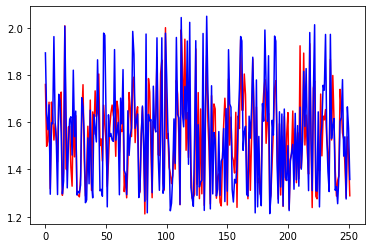

In [132]:
x_values = np.arange(len(preds_DNN_values))
y_pred_DNN = list(preds_DNN_values)
y_actual = list(y_test)

DNN = figure(y_range=(1.1,2.2),height=400,width=800,title = 'Predictions vs rates (Dense neural net) r2_score = 0.662',x_axis_label = '#',y_axis_label = 'rate')
DNN.line(x_values,y_pred_DNN,color="red",line_width=1,legend_label="Predicted")
DNN.line(x_values,y_actual,color="blue",line_width=1,legend_label="Actual")
#show(DNN)

plt.plot(x_values,y_pred_DNN,color="red")
plt.plot(x_values,y_test,color="blue")

---
MULTIPLE LINEAR REGRESSION

In [133]:
sc = MinMaxScaler(feature_range=(0,1))

X = GBP_df.iloc[:,3:-1]
y = GBP_df.iloc[:,-1]

X = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [134]:
regressor_MLR = LinearRegression()
regressor_MLR.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [135]:
predictions_MLR = regressor_MLR.predict(X_test)

In [136]:
r2_score(predictions_MLR, y_test)

0.012244977042962457

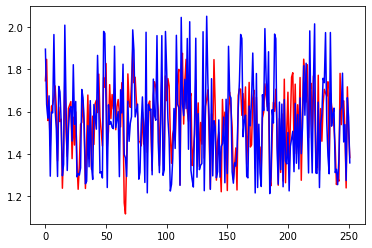

In [137]:
x_values = np.arange(len(predictions_MLR))
y_pred_MLR = list(predictions_MLR)
y_actual = list(y_test)

MLR = figure(y_range=(1.1,2.2),height=400,width=800,title = 'Predictions vs rates (Multiple Linear Regression) r2_score = 0.408',x_axis_label = '#',y_axis_label = 'rate')
MLR.line(x_values,y_pred_MLR,color="red",line_width=1,legend_label="Predicted")
MLR.line(x_values,y_actual,color="blue",line_width=1,legend_label="Actual")
#show(MLR)

plt.plot(x_values,y_pred_MLR,color="red")
plt.plot(x_values,y_test,color="blue")

---
POLYNOMIAL MODEL

In [138]:
polynomial_preprocessor = PolynomialFeatures(degree = 2) # when the degree is augmented to 3 or 4 the results overfits : 2 is default
polynomial_preprocessor.fit(X)
X_polynomial_train = polynomial_preprocessor.transform(X_train)
X_polynomial_test = polynomial_preprocessor.transform(X_test)

In [139]:
polynomial_regressor = LinearRegression()
polynomial_regressor.fit(X_polynomial_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [140]:
predictions_PM = polynomial_regressor.predict(X_polynomial_test)

In [141]:
r2_score(predictions_PM, y_test)

0.4028869424394085

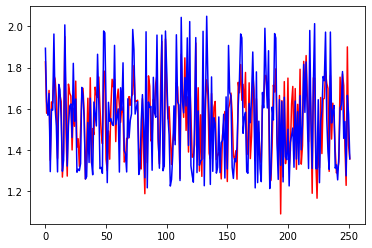

In [142]:
x_values = np.arange(len(predictions_PM))
y_pred_PM = list(predictions_PM)
y_actual = list(y_test)

PR = figure(y_range=(1.1,2.2),height=400,width=800,title = 'Predictions vs rates (Polynomial Regression) r2_score = 0.605',x_axis_label = '#',y_axis_label = 'rate')
PR.line(x_values,y_pred_PM,color="red",line_width=1,legend_label="Predicted")
PR.line(x_values,y_actual,color="blue",line_width=1,legend_label="Actual")
#show(PR)

plt.plot(np.arange(len(predictions_PM)),predictions_PM,color="red")
plt.plot(np.arange(len(predictions_PM)),y_test,color="blue")

In [143]:
output_file('main.html')
plot = gridplot([[net_positions],[rates],[percentiles],[positions],[MLR],[PR],[DNN]])
show(plot)

## Adding MLR MLP and DNN predictions to the data frame

In [144]:
def mlr(data_frame):
    predictions_mlr_func = []
    for i in range(0,len(data_frame)):
        predictions_mlr_func.append(regressor_MLR.predict(sc.transform([[data_frame.loc[i][3],
                           data_frame.loc[i][4],
                           data_frame.loc[i][5],
                           data_frame.loc[i][6],
                           data_frame.loc[i][7],
                           data_frame.loc[i][8],
                           data_frame.loc[i][9],
                           data_frame.loc[i][10],
                           data_frame.loc[i][11],
                           data_frame.loc[i][12],
                           data_frame.loc[i][13]]])))
    
    return predictions_mlr_func

In [145]:
def mlp(data_frame):
    predictions_mlp_func = []
    for i in range(0,len(data_frame)):
        predictions_mlp_func.append(polynomial_regressor.predict(polynomial_preprocessor.transform([[data_frame.loc[i][3],
                                   data_frame.loc[i][4],
                                   data_frame.loc[i][5],
                                   data_frame.loc[i][6],
                                   data_frame.loc[i][7],
                                   data_frame.loc[i][8],
                                   data_frame.loc[i][9],
                                   data_frame.loc[i][10],
                                   data_frame.loc[i][11],
                                   data_frame.loc[i][12],
                                   data_frame.loc[i][13]]])))
    
    return predictions_mlp_func

In [146]:
X = GBP_df.iloc[:,3:-1]

X_predict = pd.DataFrame(data=sc.transform(X),
                         columns=tf_formated_cols,
                         index=X.index)

predict_function = tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_predict,
                                                                batch_size=10,
                                                                num_epochs=1,
                                                                shuffle=False)

predicted_DNN_v2 = dnn_model.predict(input_fn=predict_function)
preds_DNN_values_v2_all = []

for element in list(predicted_DNN_v2):
    preds_DNN_values_v2_all.append(float(element['predictions']))


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\KKK~1\AppData\Local\Temp\tmpz7nhd4o_\model.ckpt-55000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [147]:
GBP_df["DNN"] = preds_DNN_values_v2_all
GBP_df["MLR"] = mlr(GBP_df)
GBP_df["MLP"] = mlp(GBP_df)

In [149]:
GBP_df["MLR"] = GBP_df["MLR"].apply(lambda x: x[0])

In [150]:
GBP_df["MLP"] = GBP_df["MLP"].apply(lambda x: x[0])

## Simulating trades w/ machine learning models
It will simulate the trading of binary options  

['Date', 'Symbol','Release', 'Long', 'Short', 'Change Long', 'Change Short',
       'Net positions', 'Total positions', 'Open interest', 'Percentile',
       'Step', 'Adj OI', 'Percentile Adj OI', 'Rates dA']

In [181]:
symbol = "GBPUSD"
duration_after_release = 7

In [184]:
for i in range(0,len(GBP_df)):
    gotcurrent_price = None 
    currrent_rate = 0
    day = GBP_df.iloc[i]["Release"]
    while gotcurrent_price == None:
        try:
            currrent_rate = float(GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == day]["close"])
            gotcurrent_price = True
        except:
            day = day - timedelta(days=1)
            
    result_of_current_position = "Loose"
    
    if float(GBP_df.iloc[i]["DNN"]) - currrent_rate >= 0:
        result_of_current_position = "Win"
    
    Trades_v4.loc[len(Trades_v4)] = [GBP_df.iloc[i]["Release"],"NaN",symbol,duration_after_release,result_of_current_position]
            
    
            

In [186]:
Trades_v4.describe()

,Date,Position,Symbol,Duration,Result
count,839,839,839,839.0,839
unique,839,1,1,1.0,2
top,2012-02-14 00:00:00,NaN,GBPUSD,7.0,Win
freq,1,839,839,839.0,427
first,2005-01-11 00:00:00,NaN,NaN,NaN,NaN
last,2021-03-23 00:00:00,NaN,NaN,NaN,NaN


In [176]:
GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == GBP_df.iloc[834]["Release"]]["close"]

4203    1.41074
Name: close, dtype: float64

In [178]:
GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == GBP_df.iloc[834]["Release"] + timedelta(days=14)]["close"]

4213    1.38898
Name: close, dtype: float64

In [152]:
GBP_df

,Date,Symbol,Release,Long,Short,Change Long,Change Short,Net positions,Total positions,Open interest,Percentile,Step,Adj OI,Percentile Adj OI,Rates dA,DNN,MLR,MLP
834,2005-01-04,BRITISH POUND STERLING,2005-01-11,24458,11935,-8673,-1045,12523,36393,75999,74.612634,1.0,0.164778,83.313468,1.38362,1.307858,1.598145,-2.440930e+20
835,2005-01-11,BRITISH POUND STERLING,2005-01-18,22756,1364,-1702,-10571,21392,24120,66467,80.810489,1.0,0.321844,92.729440,1.38362,1.391562,1.595703,-2.321965e+20
836,2005-01-18,BRITISH POUND STERLING,2005-01-25,21007,2292,-1749,928,18715,23299,64508,78.903456,1.0,0.290119,91.418355,1.40115,1.404995,1.641113,-2.009175e+20
837,2005-01-25,BRITISH POUND STERLING,2005-02-01,18616,2626,-2391,334,15990,21242,63971,76.877235,1.0,0.249957,89.392133,1.38906,1.397714,1.642578,-2.134768e+20
830,2005-02-01,BRITISH POUND STERLING,2005-02-08,19591,2898,975,272,16693,22489,65926,77.353993,1.0,0.253208,89.749702,1.39839,1.394918,1.648438,-2.329271e+20
831,2005-02-08,BRITISH POUND STERLING,2005-02-15,15190,5081,-4401,2183,10109,20271,64686,71.871275,1.0,0.156278,82.240763,1.39257,1.369052,1.640625,-2.609834e+20
832,2005-02-15,BRITISH POUND STERLING,2005-02-22,26973,4734,11783,-347,22239,31707,73291,81.406436,1.0,0.303434,92.252682,1.37150,1.372865,1.539062,-1.052032e+20
833,2005-02-22,BRITISH POUND STERLING,2005-03-01,29369,4213,2396,-521,25156,33582,79178,83.432658,1.0,0.317715,92.610250,1.36643,1.355147,1.585938,-1.540876e+20
825,2005-03-01,BRITISH POUND STERLING,2005-03-08,38182,4663,8813,450,33519,42845,79910,89.034565,1.0,0.419459,95.709178,1.38110,1.373167,1.593750,-1.454904e+20
826,2005-03-08,BRITISH POUND STERLING,2005-03-15,46451,5324,8269,661,41127,51775,99583,92.491061,1.0,0.412992,95.470799,1.39700,1.306110,1.603516,-1.734728e+20


 ## Simulating trades w/out machine learning

> Ideas for backtesting  

* Trade the biggest net position always
* Trade when the change on one side is negative and the other is positivie
* Trade the biggest position when the changes on this are positive and the opposite position are negative

>Trades_columns = ["Date","Position","Symbol","Duration","Result"]  
Trades_v1 = pd.DataFrame(columns=Trades_columns)  
Trades_v2 = pd.DataFrame(columns=Trades_columns)  
Trades_v3 = pd.DataFrame(columns=Trades_columns)  

>Currency_Columns = ["Date","Symbol","Long","Short","Change Long","Change Short","Net positions","Total positions"]   




In [104]:
symbol = "GBPUSD"
duration = 7

In [24]:
for i in range(0,len(GBPUSD_rates_frame)):
    dt_rates = dt(GBPUSD_rates_frame.iloc[i].time.year,GBPUSD_rates_frame.iloc[i].time.month,GBPUSD_rates_frame.iloc[i].time.day)
    
    for j in range(0,len(GBP_df)):
        dt_cot = dt(GBP_df.iloc[j].Date.year,GBP_df.iloc[j].Date.month,GBP_df.iloc[j].Date.day)
        
        if dt_cot == dt_rates:
            
            change_long = int(GBP_df.iloc[j][4])
            change_short = int(GBP_df.iloc[j][5])
            
            long = int(GBP_df.iloc[j].Long)
            short = int(GBP_df.iloc[j].Short)
            
            if long >= short:
                position = "Long"
                Trades_v1.loc[len(Trades_v1)] = [dt_cot,position,symbol,duration,"NA"]
                
            elif long < short:
                position = "Short"
                Trades_v1.loc[len(Trades_v1)] = [dt_cot,position,symbol,duration,"NA"]
            
            if change_long <= 0 and change_short >= 0:
                position = "Short"
                Trades_v2.loc[len(Trades_v2)] = [dt_cot,position,symbol,duration,"NA"]
                
            elif change_long >= 0 and change_short <= 0:
                position = "Long"
                Trades_v2.loc[len(Trades_v2)] = [dt_cot,position,symbol,duration,"NA"]
                
            if long >= short and change_long >= 0 and change_short <= 0:
                position = "Long"
                Trades_v3.loc[len(Trades_v3)] = [dt_cot,position,symbol,duration,"NA"]
                
            elif long < short and change_long <= 0 and change_short >= 0:
                position = "Short"
                Trades_v3.loc[len(Trades_v3)] = [dt_cot,position,symbol,duration,"NA"]

## Describing trades

In [144]:
Trades_v3

,Date,Position,Symbol,Duration,Result
0,2005-02-15,Long,GBPUSD,7,Win
1,2005-02-22,Long,GBPUSD,7,Win
2,2005-04-05,Long,GBPUSD,7,Win
3,2005-05-10,Long,GBPUSD,7,Loose
4,2005-05-24,Short,GBPUSD,7,Win
5,2005-05-31,Short,GBPUSD,7,Loose
6,2005-06-14,Short,GBPUSD,7,Loose
7,2005-06-28,Short,GBPUSD,7,Win
8,2005-07-12,Short,GBPUSD,7,Win
9,2005-08-16,Long,GBPUSD,7,Loose


In [145]:
Trades_v2

,Date,Position,Symbol,Duration,Result
0,2005-01-18,Short,GBPUSD,7,Win
1,2005-01-25,Short,GBPUSD,7,Loose
2,2005-02-08,Short,GBPUSD,7,Loose
3,2005-02-15,Long,GBPUSD,7,Win
4,2005-02-22,Long,GBPUSD,7,Win
5,2005-03-22,Short,GBPUSD,7,Win
6,2005-03-29,Short,GBPUSD,7,Loose
7,2005-04-05,Long,GBPUSD,7,Win
8,2005-05-03,Short,GBPUSD,7,Win
9,2005-05-10,Long,GBPUSD,7,Loose


In [151]:
Trades_v1_s = Trades_v1

## Determine profitability

In [141]:
for i in range(0,len(Trades_v1)):
    
    position = Trades_v1.loc[i].Position
    
    try:
        open_price = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v1.loc[i].Date].close)
    except:
        try:
            open_price = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v1.loc[i].Date].iloc[0].close)
        except:
            continue
    try:   
        close_price = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v1.loc[i].Date + timedelta(days=Trades_v1.loc[i].Duration)].close)
    except:
        try:
            close_prices = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v1.loc[i].Date + timedelta(days=Trades_v1.loc[i].Duration)].iloc[0].close)
        except:
            continue
            
    if position == "Long":
        if open_price < close_price:
            result = "Win"
            Trades_v1.at[i,"Result"] = result 
          
        elif open_price > close_price:
            result = "Loose"
            Trades_v1.at[i,"Result"] = result 
      
        
    if position == "Short":
        if open_price > close_price:
            result = "Win"
            Trades_v1.at[i,"Result"] = result 
          
        elif open_price < close_price:
            result = "Loose"
            Trades_v1.at[i,"Result"] = result 
    
    '''
    print ("\n============================")
    print(position)
    print(open_price)
    print(close_price)
    print(result)
    print ("============================\n")
    '''

In [142]:
for i in range(0,len(Trades_v2)):
    
    position = Trades_v2.loc[i].Position
    
    try:
        open_price = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v2.loc[i].Date].close)
    except:
        try:
            open_price = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v2.loc[i].Date].iloc[0].close)
        except:
            continue
    try:   
        close_price = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v2.loc[i].Date + timedelta(days=Trades_v2.loc[i].Duration)].close)
    except:
        try:
            close_prices = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v2.loc[i].Date + timedelta(days=Trades_v2.loc[i].Duration)].iloc[0].close)
        except:
            continue
            
    if position == "Long":
        if open_price < close_price:
            result = "Win"
            Trades_v2.at[i,"Result"] = result 
          
        elif open_price > close_price:
            result = "Loose"
            Trades_v2.at[i,"Result"] = result 
      
        
    if position == "Short":
        if open_price > close_price:
            result = "Win"
            Trades_v2.at[i,"Result"] = result 
          
        elif open_price < close_price:
            result = "Loose"
            Trades_v2.at[i,"Result"] = result 
    

In [143]:
for i in range(0,len(Trades_v3)):
    
    position = Trades_v3.loc[i].Position

    try:
        open_price = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v3.loc[i].Date].close)
    except:
        try:
            open_price = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v3.loc[i].Date].iloc[0].close)
        except:
            continue
    try:   
        close_price = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v3.loc[i].Date + timedelta(days=Trades_v3.loc[i].Duration)].close)
    except:
        try:
            close_prices = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v3.loc[i].Date + timedelta(days=Trades_v3.loc[i].Duration)].iloc[0].close)
        except:
            continue
        
    if position == "Long":
        if open_price < close_price:
            result = "Win"
            Trades_v3.at[i,"Result"] = result 
          
        elif open_price > close_price:
            result = "Loose"
            Trades_v3.at[i,"Result"] = result 
      
        
    if position == "Short":
        if open_price > close_price:
            result = "Win"
            Trades_v3.at[i,"Result"] = result 
          
        elif open_price < close_price:
            result = "Loose"
            Trades_v3.at[i,"Result"] = result         

In [152]:
for i in range(0,len(Trades_v1_s)):
    
    position = Trades_v1_s.loc[i].Position

    try:
        open_price = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v1_s[i].Date + timedelta(days=7)].close)
    except:
        try:
            open_price = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v1_s[i].Date + timedelta(days=7)].iloc[0].close)
        except:
            continue
    try:   
        close_price = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v1_s[i].Date + timedelta(days=14)].close)
    except:
        try:
            close_prices = float (GBPUSD_rates_frame.loc[GBPUSD_rates_frame["time"] == Trades_v1_s[i].Date + timedelta(days=14)].iloc[0].close)
        except:
            continue
        
    if position == "Long":
        if open_price < close_price:
            result = "Win"
            Trades_v1_s.at[i,"Result"] = result 
          
        elif open_price > close_price:
            result = "Loose"
            Trades_v1_s.at[i,"Result"] = result 
      
        
    if position == "Short":
        if open_price > close_price:
            result = "Win"
            Trades_v1_s.at[i,"Result"] = result 
          
        elif open_price < close_price:
            result = "Loose"
            Trades_v1_s.at[i,"Result"] = result      

## Calculating WinRate 

In [147]:
v1 = Trades_v1["Result"].tolist()
w = 0
t = len(v1)

for result in v1:
    if result == "Win":
        w+=1
w/t

0.46347305389221555

In [148]:
v2 = Trades_v2["Result"].tolist()
w = 0
t = len(v2)

for result in v2:
    if result == "Win":
        w+=1
w/t

0.4731457800511509

In [149]:
v3 = Trades_v3["Result"].tolist()
w = 0
t = len(v3)

for result in v3:
    if result == "Win":
        w+=1
w/t

0.4786729857819905

In [153]:
v1 = Trades_v1_s["Result"].tolist()
w = 0
t = len(v1)

for result in v1:
    if result == "Win":
        w+=1
w/t

0.46347305389221555

In [187]:
GBP_df.to_csv("GBP_prices_mod.csv", index = False)
GBPUSD_rates_frame.to_csv("GBP_rates.csv", index = False)